In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from scipy.spatial import distance
import pathlib
import os
from sklearn.decomposition import PCA
import json
import random
from random import sample

random.seed(30)

In [2]:
# Set data input folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)

In [3]:
#load the cell counts from the supplmental_6
counts = pd.read_csv('single_cell_profiles/outputs/HeLa_SABER_screen_SABER_arm_cell_count.csv.gz')

#load barcodes used in experiment
saber_library = pd.read_csv("../common_files/SABER_Library_ngt_Included_Oligo_Sequences_Assiged.csv")
guide_list = list(saber_library['sgRNA'])

# Import the guide-level profiles
df_guide = pd.read_csv("outputs/20240202_6W_CP498_SABER_Pilot_HeLa_SABER_only_guide_normalized_merged_feature_select_median_ALLWELLS.csv.gz")

# Load p_values from the hit calling process
df_p_values = pd.read_csv('outputs/HeLa_SABER_significant_features_mann_whitney_p_values.csv.gz')
df_p_values = df_p_values.set_index('Gene')
    
# Load hits from the hit calling process
whole_cell_hits = pd.read_csv('outputs/HeLa_SABER_plate_level_median_per_feat_sig_genes_1_FDR_whole_cell_hits.csv')
comp_spec_hits = pd.read_csv('outputs/HeLa_SABER_plate_level_median_per_feat_sig_genes_1_FDR_compartment_specific_hits.csv')
all_hits = pd.concat([whole_cell_hits,comp_spec_hits])
hit_list = list(comp_spec_hits.Gene) + list(whole_cell_hits.Gene)
df_guide_hits = df_guide[df_guide['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(hit_list)]
df_guide_cell_hits = df_guide[df_guide['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(list(whole_cell_hits.Gene))]
df_guide_cell_hits

,Metadata_Foci_Barcode_MatchedTo_GeneCode,Metadata_Foci_Barcode_MatchedTo_Barcode,Cells_AreaShape_CentralMoment_0_1,Cells_AreaShape_CentralMoment_0_3,Cells_AreaShape_CentralMoment_1_0,Cells_AreaShape_CentralMoment_1_1,Cells_AreaShape_CentralMoment_1_2,Cells_AreaShape_CentralMoment_1_3,Cells_AreaShape_CentralMoment_2_1,Cells_AreaShape_CentralMoment_2_3,...,Nuclei_Texture_SumEntropy_PRSP6_10_01_256,Nuclei_Texture_SumVariance_NfKb_10_01_256,Nuclei_Texture_SumVariance_Syto9_10_00_256,Nuclei_Texture_SumVariance_Syto9_10_01_256,Nuclei_Texture_SumVariance_Syto9_10_02_256,Nuclei_Texture_SumVariance_Syto9_10_03_256,Nuclei_Texture_SumVariance_TDP43_10_01_256,Nuclei_Texture_SumVariance_TDP43_10_02_256,Nuclei_Texture_SumVariance_TDP43_10_03_256,Nuclei_Texture_Variance_Syto9_10_01_256
8,ABCF1,GATGGAGTATGAGCGCCAAG,-0.006347,-0.184670,-0.509440,1.771000,-0.097276,1.501800,-0.651390,-0.543180,...,1.757300,-0.90977,0.561180,0.003830,0.674350,0.295410,0.863750,1.70780,0.779990,0.670530
9,ABCF1,GCAACACATCAATGTTGGGA,-0.060312,0.237110,-0.527040,-0.069327,0.205630,0.433230,-0.724290,-0.221000,...,0.075442,-1.01140,-0.175720,-0.068645,-0.057336,-0.628670,1.579400,1.39980,1.404400,-0.551320
10,ABCF1,GCGGGAGGACATCTCCGCCT,-0.060312,0.058797,0.028693,-0.891150,0.128650,-0.279750,0.736390,0.099630,...,0.666350,-0.42782,-0.369850,-0.547420,-0.480620,-0.541440,0.681650,0.28029,0.561440,-0.528090
11,ABCF1,TGTAATTGCCCCTATAGTAG,-2.748800,0.873180,-0.489420,-1.005400,-0.183920,-0.633640,-1.496900,-0.039453,...,2.126100,-1.14340,1.173800,0.218530,-0.156930,-0.222310,0.706470,0.66483,1.372200,0.618930
16,ACTR2,AAACACATTGTGCTTTCTGG,0.975690,-0.095817,0.288520,0.028459,-0.415380,-0.036659,0.253980,0.081194,...,1.286600,4.00840,2.364500,2.650000,2.574500,1.245900,-0.555200,0.76598,-0.880630,3.253500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2355,ZNF131,TTCACACTTGAAACTCTCAG,-0.212220,0.067546,-0.227800,-0.399800,0.202580,-0.129730,-0.002903,-0.094863,...,-0.298020,-0.41298,-0.017322,0.385270,0.503560,0.212660,-0.137590,-0.33241,-0.028615,0.173370
2356,ZNHIT6,CAATGGATTCACCAAGAGGA,-0.673420,0.341320,1.268300,0.620520,0.386450,0.599320,0.596940,0.383800,...,3.202300,2.63940,3.254000,3.066900,3.283000,2.898800,-0.195570,1.70520,0.002321,2.493100
2357,ZNHIT6,CCTCCGATAAATCACCCGGT,0.001845,0.047350,0.547330,-0.010489,0.684260,-0.065428,-0.072954,0.062614,...,0.565520,0.28315,0.246110,0.383230,0.188570,0.486640,-0.471750,0.10235,-0.119970,0.061642
2358,ZNHIT6,GACATGAAAGTTCTTCACCA,0.018373,0.855010,0.538510,-0.372040,-0.250900,-0.147310,0.143530,-0.000957,...,-0.041265,0.12624,-0.118190,-0.456900,-0.392630,-0.512970,0.075881,-0.00945,-0.082326,-0.281200


In [4]:
def perform_pca(df_guide_hits):
    df_temp = df_guide_hits.copy(deep=True)
    df_temp['Gene'] = df_temp['Metadata_Foci_Barcode_MatchedTo_GeneCode'] + ' ' + df_temp['Metadata_Foci_Barcode_MatchedTo_Barcode']
    order = ['Gene']+list(df_temp.columns[:-1])
    df_temp = df_temp[order]
    df_temp = df_temp.drop(columns=['Metadata_Foci_Barcode_MatchedTo_GeneCode','Metadata_Foci_Barcode_MatchedTo_Barcode']).set_index('Gene')
    # Perform principal component analysis on hit lists

    pca = PCA()
    pca.fit(df_temp)
    x = list(pca.explained_variance_ratio_)
    # Find principal component that represents 90% variation
    PCA_lookup = {}
    condition = 'HeLa_SABER'
    for i in range(len(x)):
        distance = abs(.9-sum(x[:i+1]))
        PCA_lookup[distance] = i 
    component = PCA_lookup[min(PCA_lookup.keys())]+1
    print (f'For {condition}, principal component representing closest to 90% variation is {component}')
    # Perform principal component analysis and select components representing 90% of variation in data
    pca = PCA(n_components=component)
    df_pca = pd.DataFrame(pca.fit_transform(df_temp),index=df_temp.index)
    df_pca = df_pca.reset_index()
    df_pca[['Metadata_Foci_Barcode_MatchedTo_GeneCode','Metadata_Foci_Barcode_MatchedTo_Barcode']] = df_pca.Gene.str.split(' ', expand = True)
    order = ['Metadata_Foci_Barcode_MatchedTo_GeneCode','Metadata_Foci_Barcode_MatchedTo_Barcode']+list(df_pca.columns[1:-2])
    df_pca = df_pca[order]
    return df_pca

pca_cell_df = perform_pca(df_guide_cell_hits) 
pca_df = perform_pca(df_guide_hits)
pca_df

For HeLa_SABER, principal component representing closest to 90% variation is 83
For HeLa_SABER, principal component representing closest to 90% variation is 114


,Metadata_Foci_Barcode_MatchedTo_GeneCode,Metadata_Foci_Barcode_MatchedTo_Barcode,0,1,2,3,4,5,6,7,...,104,105,106,107,108,109,110,111,112,113
0,ABCF1,GATGGAGTATGAGCGCCAAG,10.641895,-27.960107,-14.851312,2.070529,-11.813078,7.060244,-5.413957,13.031814,...,0.306032,1.662350,0.472013,-1.282123,0.311393,0.721975,-0.849844,1.044058,-0.406032,-0.727843
1,ABCF1,GCAACACATCAATGTTGGGA,-3.702526,-10.082178,-12.091345,-3.046732,-4.644052,4.436233,-6.631286,-0.168032,...,0.427189,0.434249,-0.067869,-0.698351,0.388892,-0.366047,-1.713089,-1.075395,0.620221,-0.046494
2,ABCF1,GCGGGAGGACATCTCCGCCT,-4.828382,-21.700209,-8.714506,-12.690299,-1.239586,-3.305725,2.469569,6.737414,...,0.028643,-0.293627,-0.723955,0.175502,-0.166404,-0.893725,0.494030,0.488966,0.717774,-0.606218
3,ABCF1,TGTAATTGCCCCTATAGTAG,1.736014,-26.698686,-16.659658,13.602528,-18.992513,4.181987,-11.759359,13.379267,...,0.717595,1.671650,2.747961,0.410385,1.269065,-0.280738,0.944317,1.001151,-0.824786,-1.090824
4,ACTR2,AAACACATTGTGCTTTCTGG,103.280284,37.678092,39.706633,-15.199107,4.315735,3.716936,3.887016,-7.494942,...,0.619047,0.565788,-0.561555,1.152165,-1.584479,2.812087,0.174095,-0.974812,2.311191,-0.143760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,ZNF131,TTCACACTTGAAACTCTCAG,-14.391527,-4.971969,-2.581611,-1.028649,4.391718,0.463594,1.119481,-1.529988,...,-0.355994,0.011943,0.116587,0.105783,-0.122288,-0.602904,-0.355259,-0.451306,0.572152,0.959414
1568,ZNHIT6,CAATGGATTCACCAAGAGGA,69.296202,-15.717136,-11.403819,37.824323,-3.640037,5.777558,-5.720203,-1.215742,...,-2.627012,0.933046,-0.077830,0.827705,0.414925,-0.140713,1.568973,0.077802,1.072570,-0.632917
1569,ZNHIT6,CCTCCGATAAATCACCCGGT,11.993745,-1.973297,-6.357813,3.056230,0.346046,2.027098,1.507244,-0.072007,...,0.278427,-0.590593,0.085242,-0.769883,-0.329279,0.181346,0.665969,1.252786,-0.312129,-0.840243
1570,ZNHIT6,GACATGAAAGTTCTTCACCA,-0.068725,-2.227938,-12.762205,-5.574070,0.424617,-2.291619,4.823488,1.268494,...,-0.532807,0.429445,-0.077728,-0.758445,0.171884,0.347152,0.463928,0.132980,0.301467,0.217548


In [5]:
# Function to calculate correleations, cluster and draw heatmap 
def heat_map(data,title,file_name,font_scale=0.8):
        corr = data.corr()
        
        plt.clf()
        
        sns.set(font_scale=font_scale,rc={'figure.figsize':(30,30)})

        ax = sns.heatmap(
            corr, 
            vmin=-1, vmax=1, center=0,
            cmap = sns.diverging_palette(250, 10 ,s=100,l=35, n=100),
            linewidth = 0.1,
            linecolor = 'white',
            square = True,
            cbar=False,
            cbar_kws = {"shrink": .76}
        )
        ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=90,
            horizontalalignment='right'
        )

        ax.set_title(title,fontsize=30)
        plt.tight_layout()
        fig = ax.get_figure()
        plt.show()
        fig.savefig(os.path.join(output_folder,f'{file_name}'),dpi=300)
        

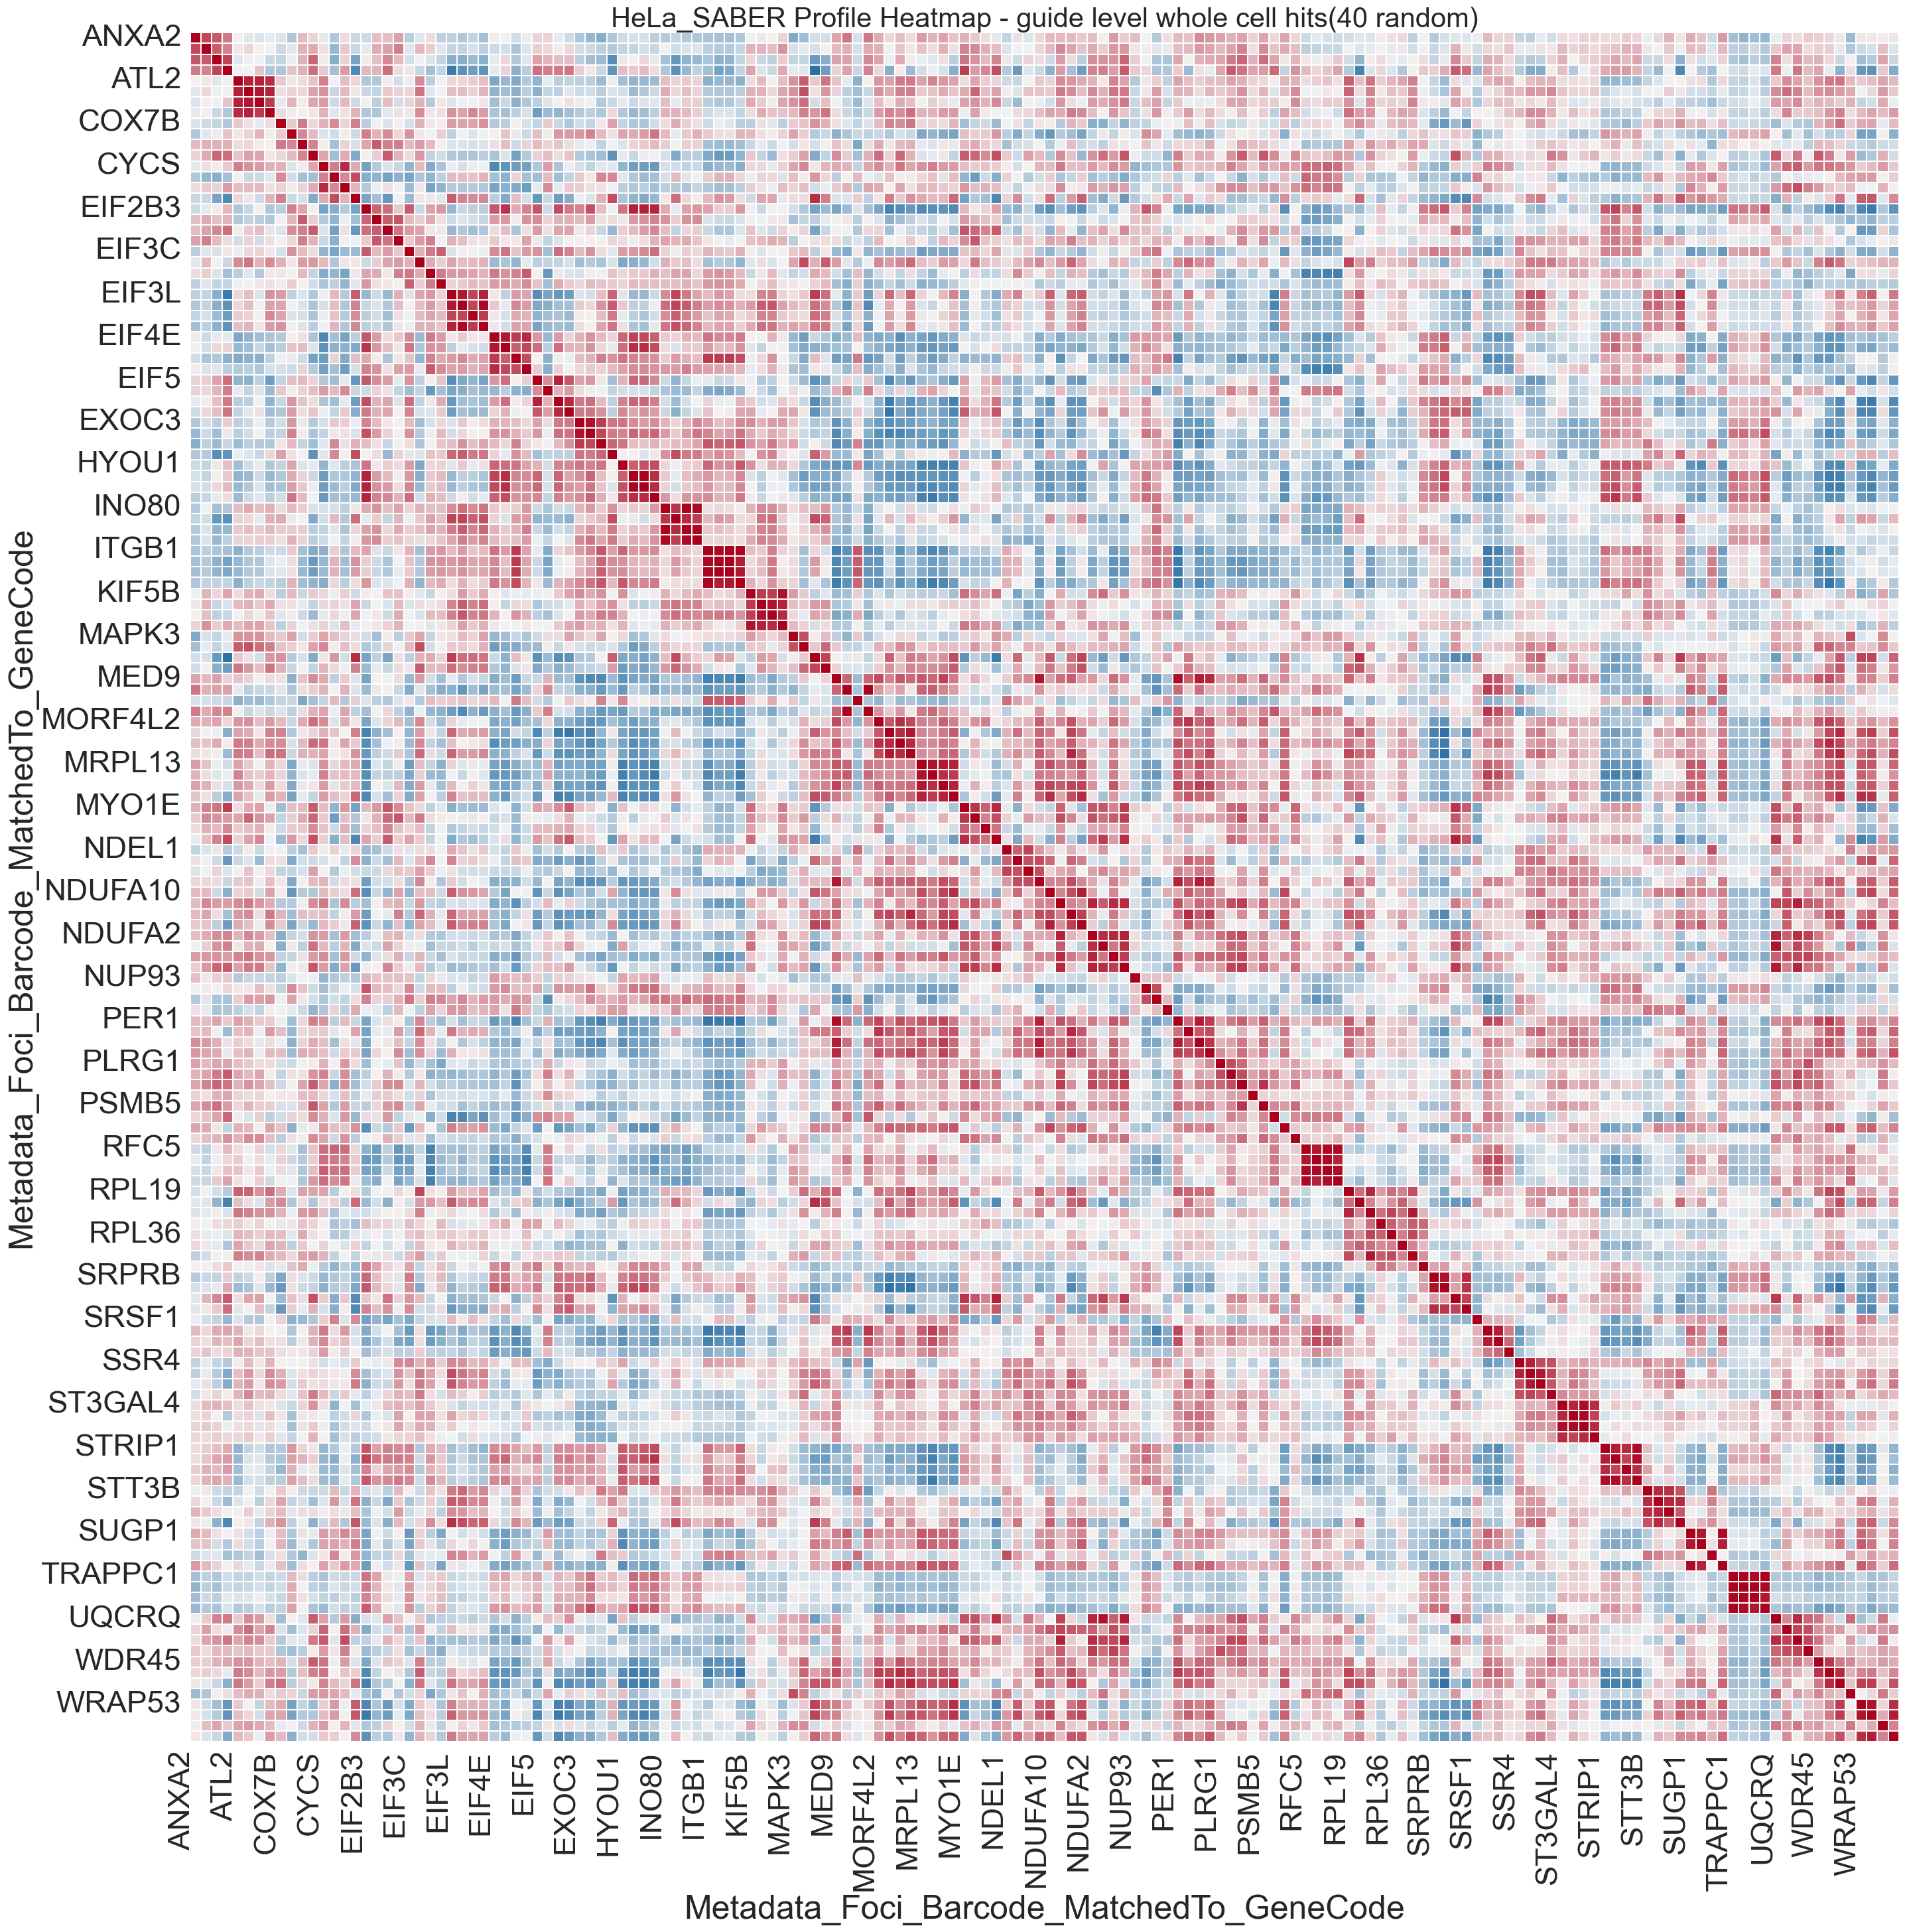

In [7]:
# Subset the data and draw heat-maps for guides with high guide count
def draw_high_count_heat_maps(hit_list, profile_df, data_set, font_scale):
    random.seed(13)
    genes_list = sample(hit_list,40)
    genes_df = profile_df[profile_df['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genes_list)]
    genes_profiles = genes_df.drop('Metadata_Foci_Barcode_MatchedTo_Barcode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
    heat_map(genes_profiles.T,
                       f'{data_set} Profile Heatmap - guide level whole cell hits(40 random)',
                       f'{data_set}_profile_heatmap_guide_level_whole_cell_hits_40_random.png',
                       font_scale)
    

draw_high_count_heat_maps(list(whole_cell_hits.Gene), pca_cell_df, 'HeLa_SABER', 3)


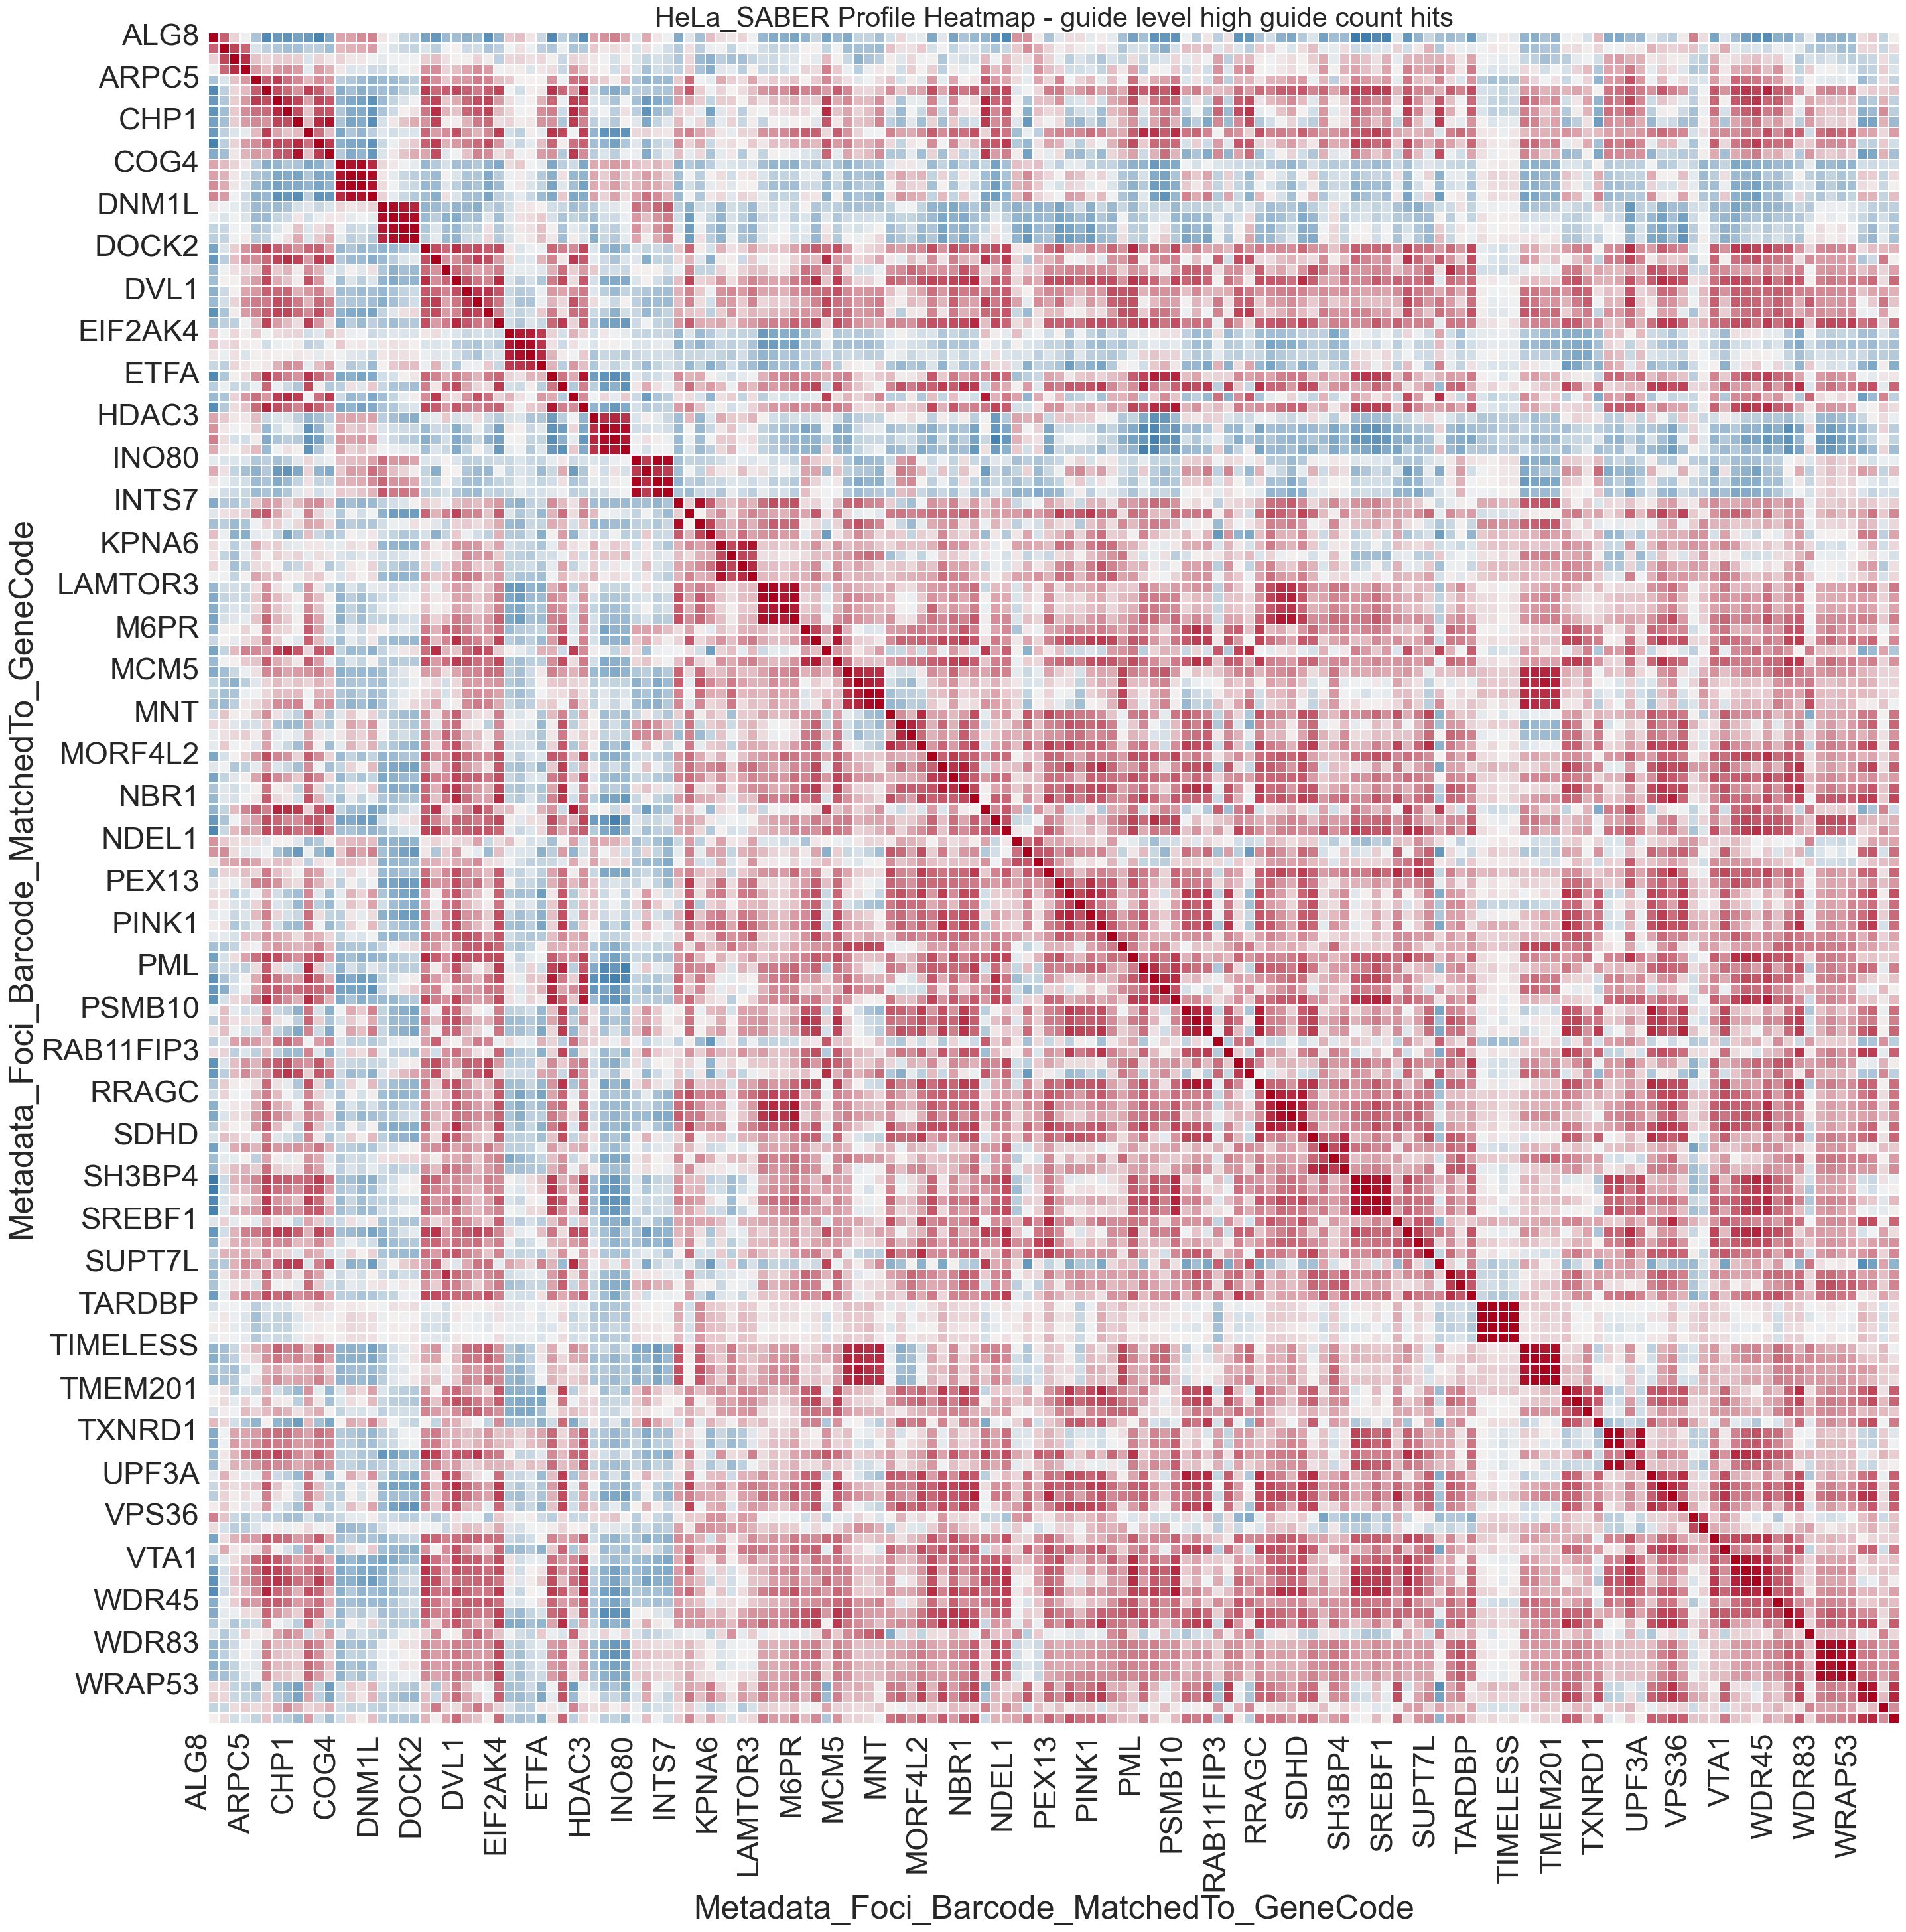

In [8]:
# find a cell count per guide to determine highly represented guides for each data set
for guide_count in range(50,1000,1): # adjust the range based on the cell count data
    hit_counts = counts[counts['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(hit_list)]
    hit_counts = hit_counts.query(f"Cell_Count > {guide_count}").groupby('Metadata_Foci_Barcode_MatchedTo_GeneCode').count()
    high_guide_list = list(hit_counts.query("Cell_Count > 3").index)
    if len(high_guide_list) <= 50:
        guide_count = guide_count-1
        break

# Subset the data and draw heat-maps for guides with high guide count
def draw_high_count_heat_maps(counts, guide_count, hit_list, profile_df, data_set, font_scale):
    hit_counts = counts[counts['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(hit_list)]
    hit_counts = hit_counts.query(f"Cell_Count > {guide_count}").groupby('Metadata_Foci_Barcode_MatchedTo_GeneCode').count()
    high_guide_list = list(hit_counts.query("Cell_Count > 3").index)
    random.seed(13)
    genes_list = sample(high_guide_list,40)
    genes_df = profile_df[profile_df['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genes_list)]
    genes_profiles = genes_df.drop('Metadata_Foci_Barcode_MatchedTo_Barcode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
    heat_map(genes_profiles.T,
                       f'{data_set} Profile Heatmap - guide level high guide count hits',
                       f'{data_set}_profile_heatmap_guide_level_high_guide_count_hits.png',
                       font_scale)
    

draw_high_count_heat_maps(counts, guide_count, hit_list, pca_df, 'HeLa_SABER', 3)


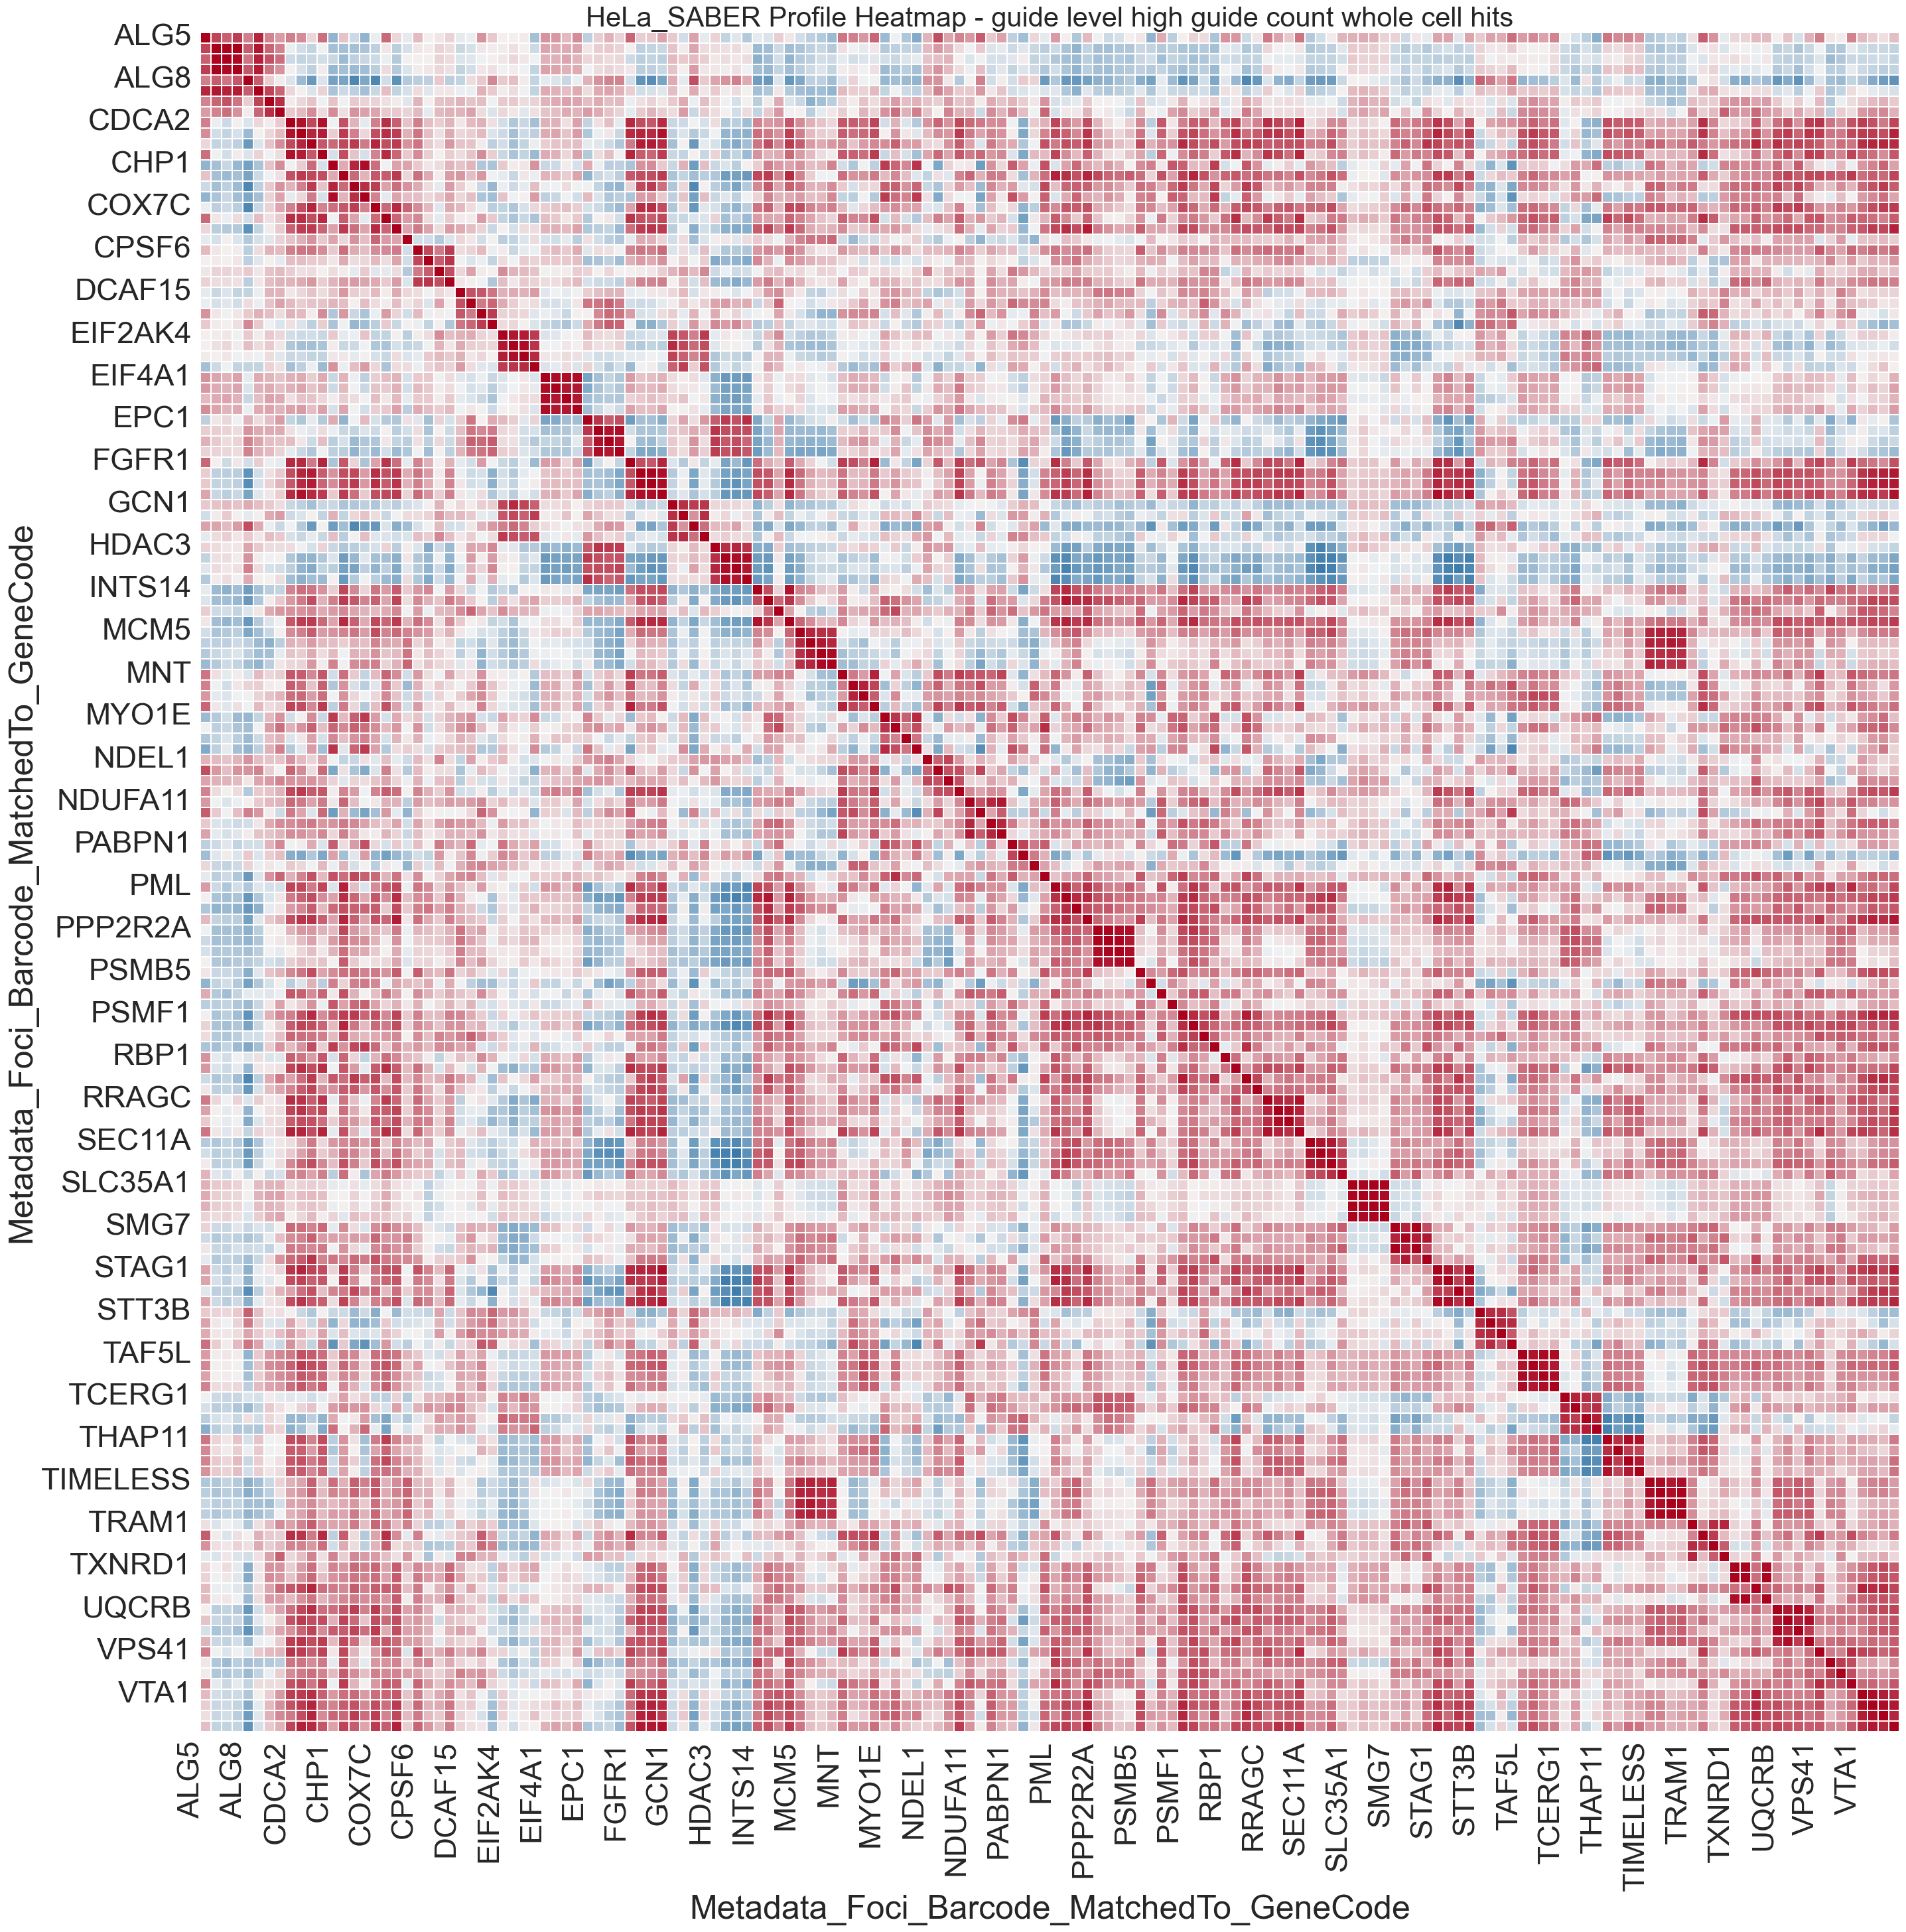

In [9]:
# find a cell count per guide to determine highly represented guides for each data set
for guide_count in range(50,1000,1): # adjust the range based on the cell count data
    hit_counts = counts[counts['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(list(whole_cell_hits.Gene))]
    hit_counts = hit_counts.query(f"Cell_Count > {guide_count}").groupby('Metadata_Foci_Barcode_MatchedTo_GeneCode').count()
    high_guide_list = list(hit_counts.query("Cell_Count > 3").index)
    if len(high_guide_list) <= 50:
        guide_count = guide_count-1
        break

# Subset the data and draw heat-maps for guides with high guide count
def draw_high_count_heat_maps(counts, guide_count, hit_list, profile_df, data_set, font_scale):
    hit_counts = counts[counts['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(hit_list)]
    hit_counts = hit_counts.query(f"Cell_Count > {guide_count}").groupby('Metadata_Foci_Barcode_MatchedTo_GeneCode').count()
    high_guide_list = list(hit_counts.query("Cell_Count > 3").index)
    random.seed(13)
    genes_list = sample(high_guide_list,40)
    genes_df = profile_df[profile_df['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genes_list)]
    genes_profiles = genes_df.drop('Metadata_Foci_Barcode_MatchedTo_Barcode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
    heat_map(genes_profiles.T,
                       f'{data_set} Profile Heatmap - guide level high guide count whole cell hits',
                       f'{data_set}_profile_heatmap_guide_level_high_guide_count_whole_cell_hits.png',
                       font_scale)
    

draw_high_count_heat_maps(counts, guide_count, list(whole_cell_hits.Gene), pca_cell_df, 'HeLa_SABER', 3)


In [10]:
guide_count

999